# This is the final project code.

### Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


### Import the data




In [ ]:
# Link to the folder: https://docs.google.com/spreadsheets/d/1IMCtjgX_q9Vr_PnoC2F5-x-it4ZQE3M_McSMejWCpVA/edit?usp=sharing
# The folder is made public.

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from google.colab import auth
import gspread
from google.auth import default

'''
1=GreaterThan1%Drop, 2=NormalDrop, 3=Flat, 4=NormalRise, 5=GreaterThan1%Rise
'''

#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Fetch data into DataFrame
googlesheet = gc.open('HistoricalData').worksheet('Clean')
rows = googlesheet.get_all_values()
data = pd.DataFrame(rows)
data.rename(columns=data.iloc[0], inplace = True)
data.drop(data.index[0], inplace = True)

# Display the data
data.tail()

,Date,Open,High,Low,Close*,Volume(MM),%Change,MACD,MACDsig,RS,RSI,Stochastic%K,Stochastic%D,Consecutive Move,Sum of % change during consecutive,Fed Rate,Class
3301,"Apr 11, 2023","4,110.29","4,124.26","4,102.61","4,108.94","3,665.83",0.00%,33.53,16.74,2.48,71.25,89.20,88.78,1.00,0.00%,4.75%,3
3302,"Apr 12, 2023","4,121.72","4,134.37","4,086.94","4,091.95","3,633.12",-0.41%,33.55,20.10,1.72,63.26,81.16,86.55,2.00,-0.42%,4.75%,2
3303,"Apr 13, 2023","4,100.04","4,150.26","4,099.40","4,146.22","3,596.59",1.33%,37.51,23.58,4.64,82.26,98.32,89.56,1.00,1.33%,4.75%,5
3304,"Apr 14, 2023","4,140.11","4,163.19","4,113.20","4,137.64","3,575.69",-0.21%,39.50,26.77,3.86,79.41,89.94,89.81,1.00,-0.21%,4.75%,3
3305,"Apr 17, 2023","4,137.17","4,151.72","4,123.18","4,151.32","3,611.18",0.33%,41.70,29.75,3.73,78.84,94.39,94.22,1.00,0.33%,4.75%,4


## Exploratory Data Analysis & Pre-processing

In [ ]:
#Convert 'Date' column from object to datatime dtype.

data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
#Extract year from the Date column and store it in a new column named 'Year'
data['Year'] = data['Date'].dt.strftime('%Y')

In [ ]:
data['Year'] = data['Year'].astype('int')

In [ ]:
#Drop Date column from the data frame

data = data.drop(['Date'], axis=1)

In [ ]:
df = data

In [ ]:
df.dtypes

Open                                  object
High                                  object
Low                                   object
Close*                                object
Volume(MM)                            object
%Change                               object
MACD                                  object
MACDsig                               object
RS                                    object
RSI                                   object
Stochastic%K                          object
Stochastic%D                          object
Consecutive Move                      object
Sum of % change during consecutive    object
Fed Rate                              object
Class                                 object
Year                                   int64
dtype: object

In [ ]:
df['weights'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

In [ ]:
df = df.drop(['Year'], axis=1)

In [ ]:
#pop the weights column and store it to use during model training

weights = df.pop('weights')

In [ ]:
data = data.drop(['weights'], axis=1)

In [ ]:
df.tail()

,Open,High,Low,Close*,Volume(MM),%Change,MACD,MACDsig,RS,RSI,Stochastic%K,Stochastic%D,Consecutive Move,Sum of % change during consecutive,Fed Rate,Class
3301,"4,110.29","4,124.26","4,102.61","4,108.94","3,665.83",0.00%,33.53,16.74,2.48,71.25,89.20,88.78,1.00,0.00%,4.75%,3
3302,"4,121.72","4,134.37","4,086.94","4,091.95","3,633.12",-0.41%,33.55,20.10,1.72,63.26,81.16,86.55,2.00,-0.42%,4.75%,2
3303,"4,100.04","4,150.26","4,099.40","4,146.22","3,596.59",1.33%,37.51,23.58,4.64,82.26,98.32,89.56,1.00,1.33%,4.75%,5
3304,"4,140.11","4,163.19","4,113.20","4,137.64","3,575.69",-0.21%,39.50,26.77,3.86,79.41,89.94,89.81,1.00,-0.21%,4.75%,3
3305,"4,137.17","4,151.72","4,123.18","4,151.32","3,611.18",0.33%,41.70,29.75,3.73,78.84,94.39,94.22,1.00,0.33%,4.75%,4


In [ ]:
label_df = df.pop('Class')

In [ ]:
input_df = df

In [ ]:
column_names = list(input_df.columns.values)

#Changed some lines to get rid of commas and percentage signs, added 'Fed Rate' at second if-condition.
for j in column_names:
  if j == 'Open' or j == 'Low' or j == 'High' or j == 'Close*' or j == 'Volume(MM)':
    #input_df[j] = input_df[j].replace(',','',regex=True)
    input_df[j] = input_df[j].str.replace(',','')
  elif j == 'Sum of % change during consecutive' or j == '%Change' or j == 'Fed Rate':
    #input_df[j] = input_df[j].replace('%','',regex=True).astype('float') / 100.0
    input_df[j] = input_df[j].str.rstrip('%').astype('float') / 100.0
  elif j == 'Stochastic%K':
    input_df[j] = input_df[j].astype('float') / 100.0
  else:
    input_df[j] = input_df[j].astype('float')

### Applying SMOTE to balance the dataset

In [ ]:
data.dtypes

Open                                  object
High                                  object
Low                                   object
Close*                                object
Volume(MM)                            object
%Change                               object
MACD                                  object
MACDsig                               object
RS                                    object
RSI                                   object
Stochastic%K                          object
Stochastic%D                          object
Consecutive Move                      object
Sum of % change during consecutive    object
Fed Rate                              object
Class                                 object
Year                                   int64
dtype: object

In [ ]:
column_names = list(data.columns.values)

for i in column_names:
  if data[i].dtype == object:
    data = data.astype({i:'string'})

In [ ]:
#split dataset into separate subsets according to the year

year_arr = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

df_dict = {}

for i in year_arr:
  df_dict[i] = data.loc[data['Year'] == i]

In [ ]:
df_dict[2010].dtypes


Open                                  string
High                                  string
Low                                   string
Close*                                string
Volume(MM)                            string
%Change                               string
MACD                                  string
MACDsig                               string
RS                                    string
RSI                                   string
Stochastic%K                          string
Stochastic%D                          string
Consecutive Move                      string
Sum of % change during consecutive    string
Fed Rate                              string
Class                                 string
Year                                   int64
dtype: object

In [ ]:
#Remove date and year from all the datasets
#Extract label column from the datasets
#Apply smote on all the datasets

df_X_dict = {}
df_y_dict = {}

df.tail()

for i in year_arr:
  df_dict[i] = df_dict[i].drop(['Year'], axis=1)
  df_y_dict[i] = df_dict[i].pop('Class')



In [ ]:
column_names = list(data.columns.values)
column_names.remove('Class')
column_names.remove('Year')


for i in year_arr:
  for j in column_names:

    temp_df = df_dict[i]
    if j == 'Open' or j == 'Low' or j == 'High' or j == 'Close*' or j == 'Volume(MM)':
      temp_df[j] = temp_df[j].str.replace(',','')
    if j == 'Sum of % change during consecutive' or j == '%Change' or j == 'Fed Rate':
      temp_df[j] = temp_df[j].str.rstrip('%').astype('float') / 100.0
    elif j == 'Stochastic%K':
      temp_df[j] = temp_df[j].astype('float') / 100.0
    else:
      temp_df[j] = temp_df[j].astype('float')

  df_dict[i] = temp_df
  df_y_dict[i] = df_y_dict[i].astype('int')

In [ ]:
from imblearn.over_sampling import SMOTE

for i in year_arr:
  oversample = SMOTE(k_neighbors=3)
  df_dict[i], df_y_dict[i] = oversample.fit_resample(df_dict[i], df_y_dict[i])

In [ ]:
concat_arr_X = []
concat_arr_y = []

for i in year_arr:
  concat_arr_X.append(df_dict[i])
  concat_arr_y.append(df_y_dict[i])

smote_input_df = pd.concat(concat_arr_X)
smote_label_df = pd.concat(concat_arr_y)

In [ ]:
smote_input_df.head()

,Open,High,Low,Close*,Volume(MM),%Change,MACD,MACDsig,RS,RSI,Stochastic%K,Stochastic%D,Consecutive Move,Sum of % change during consecutive,Fed Rate
0,1105.36,1116.11,1105.36,1115.71,3847.64,0.0102,-3.45,-10.32,3.65,78.51,0.9930,90.38,2.0,0.0116,0.0000
1,1117.01,1123.46,1116.51,1118.31,4134.68,0.0023,-1.80,-8.62,3.15,75.91,0.9197,92.36,3.0,0.0139,0.0016
2,1119.36,1125.64,1116.58,1118.79,3951.32,0.0004,-0.45,-6.98,3.55,78.04,0.8947,93.58,4.0,0.0143,0.0016
3,1119.12,1123.73,1116.66,1122.97,3945.01,0.0037,0.95,-5.40,3.24,76.44,0.9574,92.39,5.0,0.0181,0.0016
4,1125.12,1139.38,1125.12,1138.70,4133.00,0.0140,3.28,-3.66,4.75,82.60,0.9887,94.69,6.0,0.0321,0.0016


In [ ]:
smote_label_df.value_counts()

5    1201
3    1201
4    1201
2    1201
1    1201
Name: Class, dtype: int64

In [ ]:
#Adding year column to the oversampled dataset
year_col = []
for i in year_arr:
  nrows = df_dict[i].shape[0]
  temp = [i] * nrows
  year_col.extend(temp)

In [ ]:
smote_input_df['Year'] = year_col

In [ ]:
#Normalizze year column and find weights for each row according to the year

smote_input_df['weights'] = (smote_input_df['Year'] - smote_input_df['Year'].min()) / (smote_input_df['Year'].max() - smote_input_df['Year'].min())

In [ ]:
smote_input_df = smote_input_df.drop(['Year'], axis=1)

In [ ]:
smote_weights = smote_input_df.pop('weights')

In [ ]:
smote_input_df.head()

,Open,High,Low,Close*,Volume(MM),%Change,MACD,MACDsig,RS,RSI,Stochastic%K,Stochastic%D,Consecutive Move,Sum of % change during consecutive,Fed Rate
0,1105.36,1116.11,1105.36,1115.71,3847.64,0.0102,-3.45,-10.32,3.65,78.51,0.9930,90.38,2.0,0.0116,0.0000
1,1117.01,1123.46,1116.51,1118.31,4134.68,0.0023,-1.80,-8.62,3.15,75.91,0.9197,92.36,3.0,0.0139,0.0016
2,1119.36,1125.64,1116.58,1118.79,3951.32,0.0004,-0.45,-6.98,3.55,78.04,0.8947,93.58,4.0,0.0143,0.0016
3,1119.12,1123.73,1116.66,1122.97,3945.01,0.0037,0.95,-5.40,3.24,76.44,0.9574,92.39,5.0,0.0181,0.0016
4,1125.12,1139.38,1125.12,1138.70,4133.00,0.0140,3.28,-3.66,4.75,82.60,0.9887,94.69,6.0,0.0321,0.0016


### PCA visulaizzation

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [ ]:
def plot_scatter(X_pca, y):
  cmap = ListedColormap(['#FFA07A', '#FFD700', '#ADFF2F', '#00CED1', '#1E90FF'])

  # Create the scatter plot
  fig = plt.figure(figsize=(8, 6))
  for i, color in zip(np.unique(y), cmap.colors):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, label=i, edgecolors='black', linewidths=0.5, alpha=0.8)

  # Add details to the plot
  plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel('Principal Component 1', fontsize=14)
  plt.ylabel('Principal Component 2', fontsize=14)

  # Add a title and legend
  plt.title('PCA Scatter Plot', fontsize=16, fontweight='bold')
  plt.legend(title='Classes', fontsize=12, title_fontsize=12, loc='lower right', fancybox=True)

  # Save the plot as a high-quality image
  plt.savefig('scatter_plot.png', dpi=300, bbox_inches='tight')

  # Show the plot
  plt.show()

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(input_df)
y = label_df

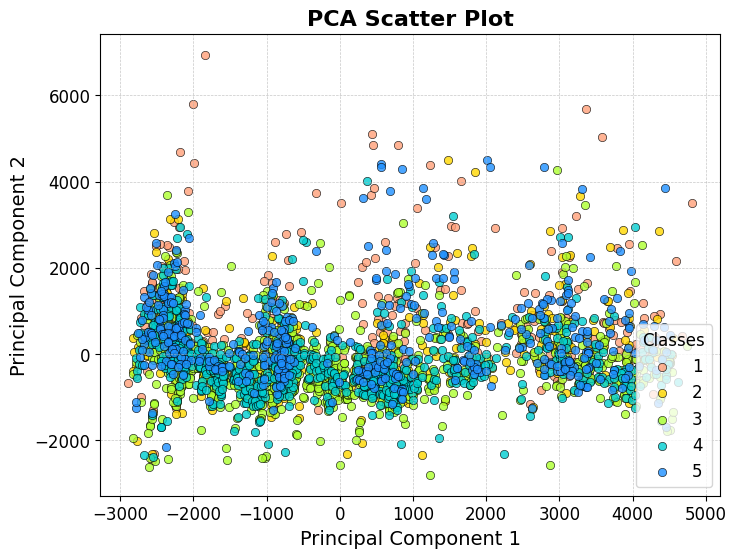

In [ ]:
plot_scatter(X_pca, y)

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(smote_input_df)
y = smote_label_df

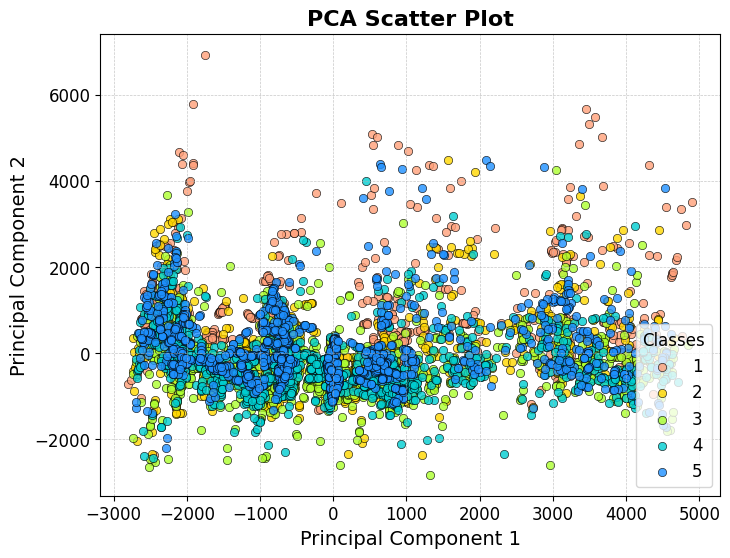

In [ ]:
plot_scatter(X_pca, y)

## Split dataset into train, validation, and test set and Normalize

### For Unbalanced dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

num_rows = input_df.shape[0]
last_20_percent = int(num_rows * 0.2)
X_train = input_df[:num_rows-last_20_percent+1]
X_test = input_df[-last_20_percent:]
y_train = label_df[:num_rows-last_20_percent+1]
y_test = label_df[-last_20_percent:]

weights_train = weights[:num_rows-last_20_percent+1]
weights_test = weights[-last_20_percent:]

#num_rows = X_test.shape[0]
#last_50_percent = int(num_rows * 0.5)
#X_val =  X_test[-last_50_percent:]
#X_test = X_test[:num_rows-last_50_percent+1]
#y_val = y_test[-last_50_percent:]
#y_test = y_test[:num_rows-last_50_percent+1]

#weights_val = weights_test[-last_50_percent:]
#weights_test = weights_test[:num_rows-last_50_percent]

train_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = train_scaler.transform(X_train)

#val_scaler = preprocessing.StandardScaler().fit(X_val)
#X_val = val_scaler.transform(X_val)

test_scaler = preprocessing.StandardScaler().fit(X_test)
X_test = test_scaler.transform(X_test)

### For SMOTE balanced dataset

In [ ]:
num_rows = smote_input_df.shape[0]
last_20_percent = int(num_rows * 0.2)
X_train_smote = smote_input_df[:num_rows-last_20_percent+1]
X_test_smote = smote_input_df[-last_20_percent:]
y_train_smote = smote_label_df[:num_rows-last_20_percent+1]
y_test_smote = smote_label_df[-last_20_percent:]

smote_weights_train = smote_weights[:num_rows-last_20_percent+1]
smote_weights_test = smote_weights[-last_20_percent:]

#num_rows = X_test_smote.shape[0]
#last_50_percent = int(num_rows * 0.5)
#X_val_smote =  X_test_smote[-last_50_percent:]
#X_test_smote = X_test_smote[:num_rows-last_50_percent+1]
#y_val_smote = y_test_smote[-last_50_percent:]
#y_test_smote = y_test_smote[:num_rows-last_50_percent+1]

#smote_weights_val = smote_weights_test[-last_50_percent:]
#smote_weights_test = smote_weights_test[:num_rows-last_50_percent]

train_scaler = preprocessing.StandardScaler().fit(X_train_smote)
X_train_smote = train_scaler.transform(X_train_smote)

#val_scaler = preprocessing.StandardScaler().fit(X_val_smote)
#X_val_smote = val_scaler.transform(X_val_smote)

test_scaler = preprocessing.StandardScaler().fit(X_test_smote)
X_test_smote = test_scaler.transform(X_test_smote)

## Training classifier on the datasets

In [ ]:
#Importing necessary libraries

import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [ ]:
def plot_learning_curve(classifier, X, y):
  '''The following function is used to plot the learning curve for both training and cross-validation accuracy
  for differnt number of training examples to find if the model is under-fitting or over-fitting'''

  plt.figure()
  plt.style.use(['ggplot'])
  plt.title("Learning curve")
  train_sizes, train_acc, test_acc = learning_curve(
        classifier, X, y, n_jobs=-1, shuffle = True, train_sizes=np.linspace(.1, 1.0, 10))

  train_acc_mean = np.mean(train_acc, axis=1)
  train_acc_std = np.std(train_acc, axis=1)
  test_acc_mean = np.mean(test_acc, axis=1)
  test_acc_std = np.std(test_acc, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_acc_mean - train_acc_std,
                     train_acc_mean + train_acc_std, alpha=0.1,
                     color="r")
  plt.fill_between(train_sizes, test_acc_mean - test_acc_std,
                     test_acc_mean + test_acc_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_acc_mean, 'o-', color="r",
             label="Training accuracy")
  plt.plot(train_sizes, test_acc_mean, 'o-', color="g",
             label="Cross-validation accuracy")

  plt.legend(loc="best")
  plt.show()

In [ ]:
parameters = [

            {
              "kernel": ["rbf", "poly," "linear"],
              "C": [0.1, 0.5, 1, 5],
              "gamma": [0.01, 0.05, 0.1]
            }
        ]

class_names = [1, 2, 3, 4, 5]

In [ ]:
def svm_classifier(X_train, X_test, y_train, y_test, parameters, sample_weight_train, sample_weight_test):
  '''The following function when called will perform an exhaustive search
      over all the parameters to find the set of parameters which give
      the best fit of parameters with lowest cross validation error'''
  svm = SVC(probability = True)

  print("finding best value for C and gamma")
  print("################")

  #Finding best parameters C and gamma using GridsearchCV

  clf = GridSearchCV(svm, param_grid = parameters,  cv=5, n_jobs=-1, verbose=2, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel(), sample_weight = sample_weight_train)
  ypred = clf.predict(X_test)

  titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true")]
  for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

  plt.show()
  tuned_clf = clf.best_estimator_
  print("###################")
  print()
  y_pred_test = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred_test, sample_weight=sample_weight_test)  # Pass sample_weight as a list
  print("Accuracy is", acc)
  print("###################")
  print()
  print(classification_report(y_test, ypred))
  return tuned_clf, ypred, acc

In [ ]:
smote_weights_train = smote_weights_train.tolist()
smote_weights_test = smote_weights_test.tolist()

finding best value for C and gamma
################
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_para

Confusion matrix, without normalization
[[172  62   2   0   0]
 [  4 195  37   0   0]
 [  0   7 228   1   0]
 [  0   0  62 173   1]
 [  0   0   6 109 142]]
Normalized confusion matrix
[[0.72881356 0.26271186 0.00847458 0.         0.        ]
 [0.01694915 0.82627119 0.15677966 0.         0.        ]
 [0.         0.02966102 0.96610169 0.00423729 0.        ]
 [0.         0.         0.26271186 0.73305085 0.00423729]
 [0.         0.         0.0233463  0.42412451 0.55252918]]


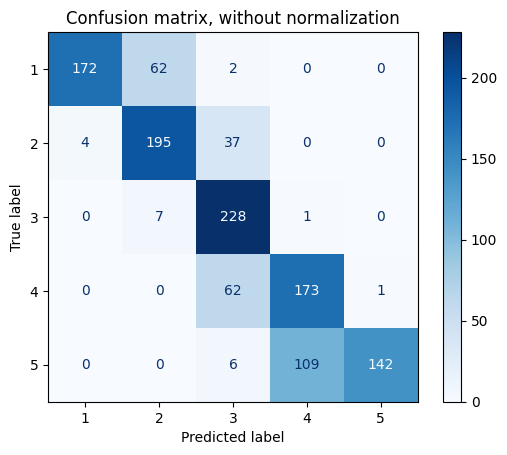

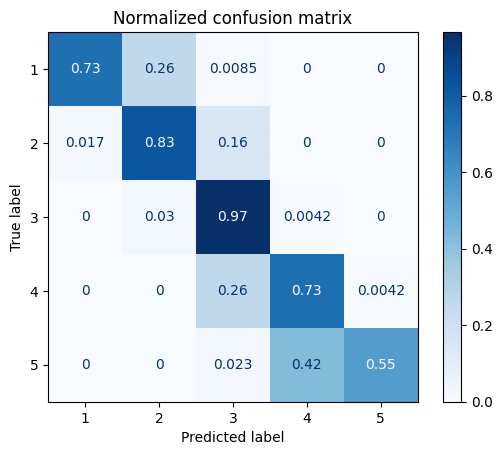

###################

Accuracy is 0.7604759054175396
###################

              precision    recall  f1-score   support

           1       0.98      0.73      0.83       236
           2       0.74      0.83      0.78       236
           3       0.68      0.97      0.80       236
           4       0.61      0.73      0.67       236
           5       0.99      0.55      0.71       257

    accuracy                           0.76      1201
   macro avg       0.80      0.76      0.76      1201
weighted avg       0.80      0.76      0.76      1201



In [ ]:
svm_tuned_clf, svm_ypred, acc = svm_classifier(X_train_smote, X_test_smote, y_train_smote, y_test_smote, parameters, smote_weights_train, smote_weights_test)

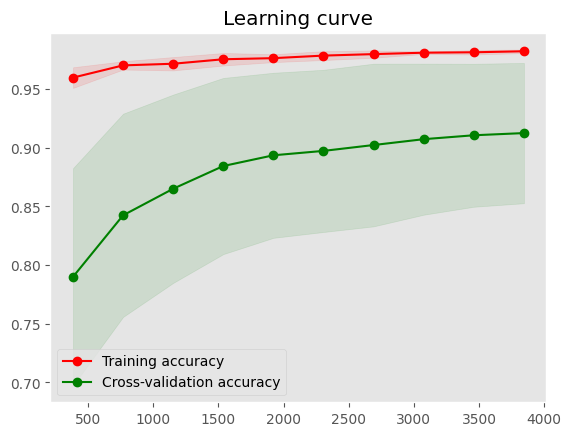

In [ ]:
plot_learning_curve(svm_tuned_clf, X_train_smote, y_train_smote)

### Random Forest Classifier

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(10, 40, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]

parameters = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

In [ ]:
def Random_forest_clf(X_train, X_test, y_train, y_test, parameters, sample_weight_train, sample_weight_test):
  '''The following function uses random forest classifier and GridsearchCV to find
     the best fit for the parameters and plot confusion matrix for the test '''

  rfc = RandomForestClassifier()
  clf = GridSearchCV(rfc, param_grid = parameters,  cv=3, n_jobs=-1, verbose=2, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel(), sample_weight = sample_weight_train)
  y_pred = clf.predict(X_test)
  y_predprob = clf.predict_proba(X_test)

  titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true")]
  for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

  tuned_clf = clf.best_estimator_
  disp.ax_.set_title('Confusion matrix')
  print("###################")
  print()
  acc = accuracy_score(y_test, y_pred, sample_weight=sample_weight_test)  # Pass sample_weight as a list
  print("Accuracy is", acc)
  print("###################")
  print()
  print(classification_report(y_test, y_pred))
  return tuned_clf, y_pred, acc

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Confusion matrix, without normalization
[[177  59   0   0   0]
 [  0 210  26   0   0]
 [  0   0 236   0   0]
 [  0   0  64 172   0]
 [  0   0   0  99 158]]
Normalized confusion matrix
[[0.75       0.25       0.         0.         0.        ]
 [0.         0.88983051 0.11016949 0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.27118644 0.72881356 0.        ]
 [0.         0.         0.         0.38521401 0.61478599]]
###################

Accuracy is 0.794971565399581
###################

              precision    recall  f1-score   support

           1       1.00      0.75      0.86       236
           2       0.78      0.89      0.83       236
           3       0.72      1.00      0.84       236
           4       0.63      0.73      0.68       236
           5       1.00      0.61      0.76       257

    accuracy                           0.79      1201
   macro a

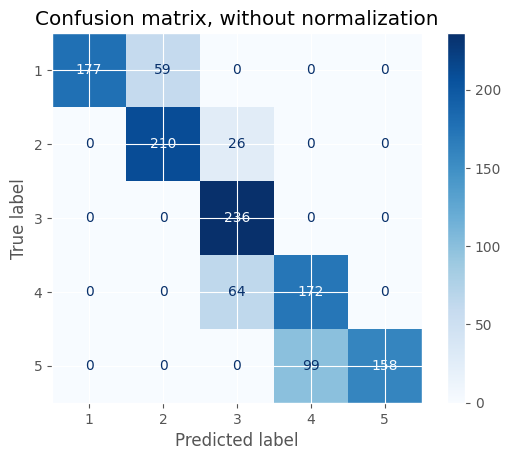

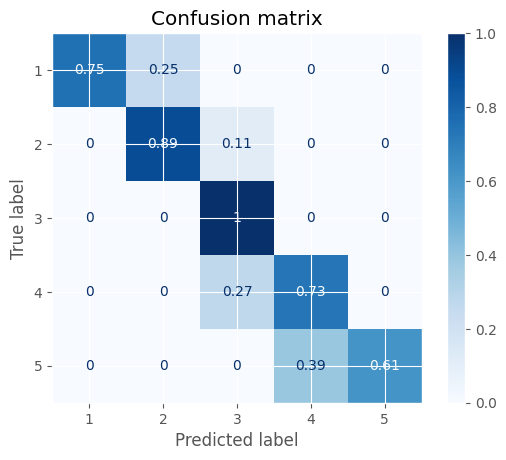

In [ ]:
rfc_tuned_clf, ypred, acc = Random_forest_clf(X_train_smote, X_test_smote, y_train_smote, y_test_smote, parameters, smote_weights_train, smote_weights_test)

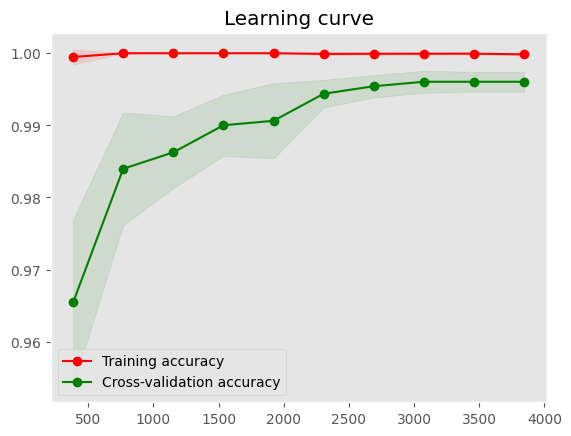

In [ ]:
plot_learning_curve(rfc_tuned_clf, X_train_smote, y_train_smote)

### Deep Neural Network

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


num_rows = smote_input_df.shape[0]
last_20_percent = int(num_rows * 0.2)
X_train_smote = smote_input_df[:num_rows-last_20_percent+1]
X_test_smote = smote_input_df[-last_20_percent:]
y_train_smote = smote_label_df[:num_rows-last_20_percent+1]
y_test_smote = smote_label_df[-last_20_percent:]

smote_weights_train = smote_weights[:num_rows-last_20_percent+1]
smote_weights_test = smote_weights[-last_20_percent:]

num_rows = X_test_smote.shape[0]
last_50_percent = int(num_rows * 0.5)
X_val_smote =  X_test_smote[-last_50_percent:]
X_test_smote = X_test_smote[:num_rows-last_50_percent+1]
y_val_smote = y_test_smote[-last_50_percent:]
y_test_smote = y_test_smote[:num_rows-last_50_percent+1]

smote_weights_val = smote_weights_test[-last_50_percent:]
smote_weights_test = smote_weights_test[:num_rows-last_50_percent]

train_scaler = preprocessing.StandardScaler().fit(X_train_smote)
X_train_smote = train_scaler.transform(X_train_smote)

val_scaler = preprocessing.StandardScaler().fit(X_val_smote)
X_val_smote = val_scaler.transform(X_val_smote)

test_scaler = preprocessing.StandardScaler().fit(X_test_smote)
X_test_smote = test_scaler.transform(X_test_smote)

In [ ]:
y_train_smote = y_train_smote - 1
y_val_smote = y_val_smote - 1
y_test_smote = y_test_smote - 1

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
y_train_smote = y_train_smote.to_numpy()
y_val_smote = y_val_smote.to_numpy()
y_test_smote = y_test_smote.to_numpy()

In [ ]:
X_train_smote = torch.from_numpy(X_train_smote).to(device)
y_train_smote = torch.from_numpy(y_train_smote).to(device)

In [ ]:
X_val_smote = torch.from_numpy(X_val_smote).to(device)
y_val_smote = torch.from_numpy(y_val_smote).to(device)

In [ ]:
X_test_smote = torch.from_numpy(X_test_smote).to(device)
y_test_smote = torch.from_numpy(y_test_smote).to(device)

In [ ]:
class ModelDataset(Dataset):
  def __init__(self, X, y):
    self.x = X
    self.y = y

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

In [ ]:
train_data = ModelDataset(X_train_smote, y_train_smote)
trainloader = DataLoader(train_data, batch_size = 32, shuffle = True)

In [ ]:
val_data = ModelDataset(X_val_smote, y_val_smote)
valloader = DataLoader(val_data, batch_size = 32, shuffle = True)

In [ ]:
test_data = ModelDataset(X_test_smote, y_test_smote)
testloader = DataLoader(test_data, batch_size = 32, shuffle = True)

In [ ]:
import torch.nn as nn
import torch

def add_layer(layerList, input_size, output_size):
  layerList.append(nn.Linear(input_size, output_size))
  return layerList

def add_activation_layer(layerList):
  layerList.append(nn.ReLU())
  return layerList

def build_NN(no_of_layers, layer_size):
  layerList = []
  for i in range(no_of_layers-2):
    layerList = add_layer(layerList, layer_size[i], layer_size[i+1])
    layerlist = add_activation_layer(layerList)

    idx = i+1

  layerList = add_layer(layerList, layer_size[idx], layer_size[idx+1])
  neuralNet = nn.Sequential(*layerList).to(device)

  return neuralNet

In [ ]:
neural_net = build_NN(3, [15, 30, 20, 5])

In [ ]:
print(neural_net)

Sequential(
  (0): Linear(in_features=15, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=20, bias=True)
)


In [ ]:
import numpy as np

In [ ]:
def train_model(model, epochs, train_loss_arr, val_loss_arr):
  min_val_loss = np.inf
  for i in range(epochs):
      train_loss = 0.0
      val_loss = 0.0
      neural_net.train()
      for data,label in trainloader:
          #label = label.type(torch.LongTensor)
          #data = data.cuda()
          #label = label.cuda()
          for name, param in model.named_parameters():
            if param.requires_grad:
              param.data = param.data.to(data.dtype)
          optimizer.zero_grad()
          output = neural_net(data)
          loss = criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

      neural_net.eval()
      for val_data, val_label in valloader:
          val_label = val_label.type(torch.LongTensor)
          #val_data = val_data.cuda()
          #val_label = val_label.cuda()
          target = neural_net(val_data)
          loss = criterion(target,val_label)
          val_loss += loss.item()

      print('Epoch:', i+1, 'Training loss:', train_loss/len(trainloader), 'Validation loss:', val_loss/len(valloader));

      if min_val_loss > val_loss:
          print(f'Validation Loss Decreased',  val_loss/len(valloader), 'Saving The Model...')
          min_val_loss = val_loss

          final_net = neural_net


      train_loss_arr.append(train_loss/len(trainloader))
      val_loss_arr.append(val_loss/len(valloader))
      print(f'Epoch: {i+1} / {epochs} \t\t\t Training Loss:{train_loss/len(trainloader)} \t\t\t Validation Loss:{val_loss/len(valloader)}')

  return final_net, train_loss_arr, val_loss_arr

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neural_net.parameters(),lr=0.00003)

In [ ]:
epochs = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loss_arr = []
val_loss_arr = []
final_net, train_loss_arr, val_loss_arr = train_model(neural_net, epochs, train_loss_arr, val_loss_arr)


y_pred = final_net(X_test_smote)
out, inds = torch.max(y_pred,dim=1)
acc = (inds.float() == y_test_smote).float().mean()
acc = float(acc)

Epoch: 1 Training loss: 3.0158618351327657 Validation loss: 2.9721299851842105
Validation Loss Decreased 2.9721299851842105 Saving The Model...
Epoch: 1 / 150 			 Training Loss:3.0158618351327657 			 Validation Loss:2.9721299851842105
Epoch: 2 Training loss: 2.9515211428016985 Validation loss: 2.911746407919845
Validation Loss Decreased 2.911746407919845 Saving The Model...
Epoch: 2 / 150 			 Training Loss:2.9515211428016985 			 Validation Loss:2.911746407919845
Epoch: 3 Training loss: 2.888900946515727 Validation loss: 2.8482417497733166
Validation Loss Decreased 2.8482417497733166 Saving The Model...
Epoch: 3 / 150 			 Training Loss:2.888900946515727 			 Validation Loss:2.8482417497733166
Epoch: 4 Training loss: 2.825561788487413 Validation loss: 2.787219577568379
Validation Loss Decreased 2.787219577568379 Saving The Model...
Epoch: 4 / 150 			 Training Loss:2.825561788487413 			 Validation Loss:2.787219577568379
Epoch: 5 Training loss: 2.7633609317100722 Validation loss: 2.72451648

In [ ]:
print(acc)

0.7109634280204773


In [ ]:
def mean_acc_class(net, loader):
  classes = np.array([0, 1, 2, 3, 4])
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  pred_arr = []
  label_arr = []
  # again no gradients needed
  with torch.no_grad():
      for data in loader:
          images, labels = data
          outputs = net(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              label = label.type(torch.int64)
              if label == prediction:
                correct_pred[classes[label]] += 1

              pred_arr.append(prediction)
              label_arr.append(label)
              total_pred[classes[label]] += 1

  print()


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      if classname == 0:
        classname = 'Class 1'
      elif classname == 1:
        classname = 'Class 2'
      elif classname == 2:
        classname = 'Class 3'
      elif classname == 3:
        classname = 'Class 4'
      else:
        classname = 'Class 5'

      print('Accuracy for class', classname, '= ', accuracy)
  return correct_pred, total_pred, pred_arr, label_arr

In [ ]:
correct_pred, total_pred, pred_arr, label_arr = mean_acc_class(neural_net, testloader)


Accuracy for class Class 1 =  88.29787234042553
Accuracy for class Class 2 =  78.18181818181819
Accuracy for class Class 3 =  63.39869281045752
Accuracy for class Class 4 =  61.904761904761905
Accuracy for class Class 5 =  70.58823529411765


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(label_arr, pred_arr, average=None)

Precision for each class

In [ ]:
print(precision)

[0.88297872 0.65151515 0.67832168 0.58646617 0.84      ]


Recall for each class

In [ ]:
from sklearn.metrics import recall_score

recall = recall_score(label_arr, pred_arr, average=None)

In [ ]:
print(recall)

[0.88297872 0.78181818 0.63398693 0.61904762 0.70588235]


F1 score for each class

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(label_arr, pred_arr, average=None)

In [ ]:
print(f1)

[0.88297872 0.7107438  0.65540541 0.6023166  0.76712329]


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(no_of_epochs, train_loss_arr, val_loss_arr):
  epochs = []
  for i in range(1, no_of_epochs):
    epochs.append(i)

  plt.plot(epochs, train_loss_arr, '-', color='blue')
  plt.plot(epochs, val_loss_arr, '-', color='green')
  plt.xlabel('Epochs')
  plt.ylabel('Train & validation Loss')
  plt.title('Epochs vs Loss curve')
  plt.legend(['Training Loss', 'Validation Loss'])


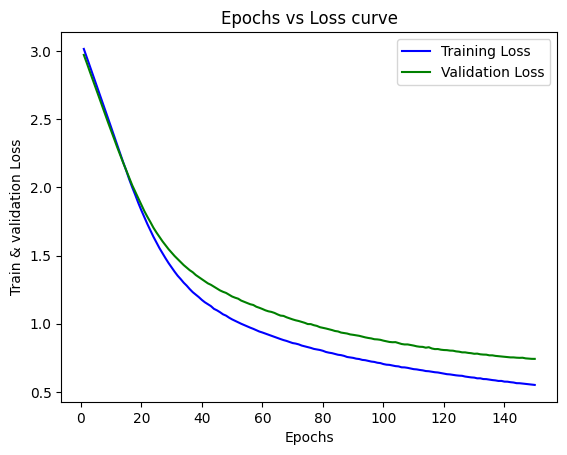

In [ ]:
plot_loss(epochs + 1, train_loss_arr, val_loss_arr)

In [ ]:
from sklearn.metrics import precision_score
weighted_precision = precision_score(label_arr, pred_arr, average='weighted')
macro_precision = precision_score(label_arr, pred_arr, average='macro')

In [ ]:
print(macro_precision)

0.7278563437309237


In [ ]:
print(weighted_precision)

0.7181139871959945


In [ ]:
from sklearn.metrics import recall_score

weighted_recall = recall_score(label_arr, pred_arr, average='weighted')
macro_recall = recall_score(label_arr, pred_arr, average='macro')

In [ ]:
print(weighted_recall)

0.7109634551495017


In [ ]:
print(macro_recall)

0.7247427610631616


In [ ]:
from sklearn.metrics import f1_score

weighted_f1 = f1_score(label_arr, pred_arr, average='weighted')
macro_f1 = f1_score(label_arr, pred_arr, average='macro')

In [ ]:
print(weighted_f1)

0.7120239341089931


In [ ]:
print(macro_f1)

0.7237135640900777
